In [13]:
import sys, os
import ROOT
ROOT.gSystem.Load("libDelphes.so")
try:
    ROOT.gInterpreter.Declare('#include "Delphes-3.5.0/classes/DelphesClasses.h"')
    ROOT.gInterpreter.Declare('#include "Delphes-3.5.0/external/ExRootAnalysis/ExRootTreeReader.h"')
except:
    pass
from ROOT import TCanvas, TLorentzVector
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
d = dict(file=sys.stdout,colour='green')
from matplotlib.font_manager import FontProperties
from matplotlib import colors
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm
#plt.style.use('seaborn')
import matplotlib
import warnings
warnings.filterwarnings("ignore") #Ignore the outputed warnings

In [1]:
class Analysis:
    
    def __init__(self,inputFile,NN):
        self.inputFile=inputFile
        self.NN = NN
        
        
    def flatten(slef,t):
        return [item for sublist in t for item in sublist]
    
    def phi_pi(slef,x):
        if (x > np.pi):  
            x= x -2*np.pi
        elif (x < -np.pi):
            x = x + 2*np.pi
        return x    

    def DeltaR(slef,x1,x2,y1,y2):
        return np.sqrt((x1-y1)**2+(x2-y2)**2)
    # Analysis in delphes to reconstruct the needed jets
    def Analysis_reco(self):
        chain= ROOT.TChain("Delphes")
        chain.Add(self.inputFile)
        # Create object of class ExRootTreeReader
        treeReader = ROOT.ExRootTreeReader(chain)
        Entries = treeReader.GetEntries()
        brancheflow = treeReader.UseBranch("eFlowChargedFilter")
        branchJet = treeReader.UseBranch("Jet")
        jet_reco_pt,jet_reco_eta,jet_reco_phi=[],[],[]
        dr,mH,ptH,etaH,phiH,dr1,pt_j=[],[],[],[],[],[],[]
        for entry in tqdm(range(0,self.NN),**d,desc ='Runing delphes analysis'):
            treeReader.ReadEntry(entry)
            if (branchJet.GetEntries() <=1):continue
            wp =0    
            b =[jet for jet in branchJet if (jet.BTag & (1 << wp))]
            if (len(b) <2):continue #at least two jets tagged as b-jets
            b1 = []
            b2 = []
            for i  in range(len(b)):
                for j in range(len(b)):
                    if i != j:
                        m = (b[i].P4()+b[j].P4()).M()
                        if(m > 110 and m < 140):
                            idx = np.argsort([b[i].P4().Pt(),b[j].P4().Pt()])
                            b1.append(b[idx[0]])
                            b2.append(b[idx[1]])
                        else:
                            continue
            if(len(b1) == 0 or len(b2)==0):continue                
            if (b1[0].P4()).Pt() < 45:continue 
            if (b2[0].P4()).Pt() < 20:continue
            if self.DeltaR(b1[0].Eta,b1[0].Phi,b2[0].Eta,b2[0].Phi) > 3.0 : continue  #for the cut plot
            #if (b[0].P4()+b[1].P4()).Pt() < 50: continue    
            dr.append(self.DeltaR(b1[0].Eta,b1[0].Phi,b2[0].Eta,b2[0].Phi)/2)
            etaH.append((b1[0].Eta+b2[0].Eta)/2)
            phiH.append((b1[0].Phi+b2[0].Phi)/2)
            ptH.append((b1[0].P4()+b2[0].P4()).Pt())
            mH.append((b1[0].P4()+b2[0].P4()).M())
        
            jet_reco_pt.append([jet.PT for jet in brancheflow if jet.PT > 1 ])
            jet_reco_eta.append([jet.Eta for jet in brancheflow if jet.PT > 1])
            jet_reco_phi.append([jet.Phi for jet in brancheflow if jet.PT > 1])
        
        return jet_reco_pt,jet_reco_eta,jet_reco_phi,dr,etaH,phiH,ptH,mH
   
    
    # Function to center all objects in (\eta,\phi)=(eta(b1)+eta(b2)/2,phi(b1)+phi(b2)/2)
    # Note the rotation in phi plane is invariant so onjects > abs(2 pi) rotated back 
    def center(self):
        pt,eta,phi,r,eta1,phi1,_,_=self.Analysis_reco()
        pt_c,eta_c,phi_c=[],[],[]
        for i in tqdm(range(len(phi)),**d,desc ='Runing b-jets centering'):
            phi_m = phi1[i]
            eta_m = eta1[i]
            phi_c.append([])
            eta_c.append([])
            pt_c.append([])
            for j in range(len(phi[i])):
                if phi[i][j]-phi_m < -np.pi:
                    phi_c[i].append(phi[i][j]-phi_m+2*np.pi)
                    eta_c[i].append(eta[i][j]-eta_m)
                    pt_c[i].append(pt[i][j]/np.array(pt[i]).max())
                elif phi[i][j]-phi_m  > np.pi:
                    phi_c[i].append(phi[i][j]-phi_m-2*np.pi)
                    eta_c[i].append(eta[i][j]-eta_m)
                    pt_c[i].append(pt[i][j]/np.array(pt[i]).max())    
                else:
                    phi_c[i].append(phi[i][j]-phi_m)        
                    eta_c[i].append(eta[i][j]-eta_m)
                    pt_c[i].append(pt[i][j]/np.array(pt[i]).max())    
                    
        return pt_c,eta_c,phi_c,r 
    
    # embed the recostructed objects in eta,phi,pt  image.
    # pixel size  = 0.1 of the eta and phi range 
    def make_image(self,etaedges,phiedges,sigma):
        pt,eta,phi,_=self.center()
        Image,xedges,yedges=[],[],[]
        for i in tqdm(range(len(pt)),**d,desc ='Runing make images'):
            histo, x, y =  np.histogram2d(eta[i],phi[i],bins=(etaedges,phiedges),weights=np.array(pt[i]),normed=None)
            Image.append(gaussian_filter(histo,sigma,mode='nearest').T)
            xedges.append(x)
            yedges.append(y)
        return Image, xedges, yedges
    
    
    
    def Riemann(self):
        x,y,z,r=self.center()
        thetaR,phiR,ptR=[],[],[]
        Dj = lambda m,n : np.sqrt(m**2+n**2)
        for i in tqdm(range(len(z)),**d,desc ='Runing Riemann analysis'):
            phiR.append([])
            thetaR.append([])
            ptR.append([])
            Rbb=  r[i]
            for j in range(len(z[i])):
                xl=0
                yy= (Dj(y[i][j],z[i][j])**2-Rbb**2)/(Dj(y[i][j],z[i][j])**2+Rbb**2) 
                if yy == 0 and z[i][j] > np.pi/2: 
                    xl = np.pi/2 - z[i][j]
                elif yy == 0 and z[i][j] < np.pi/2 and z[i][j] > 0:  
                    xl = np.pi/2 - z[i][j]    
                elif yy == 0 and z[i][j] < -np.pi/2 and z[i][j] < 0:
                    xl = -np.pi/2 - z[i][j] 
                elif yy == 0 and z[i][j] > -np.pi/2 and z[i][j] < 0:
                    xl = -np.pi/2 - z[i][j]   
                if (yy > 0.35 and x[i][j]>0.3 ): 
                    phiR[i].append(np.random.uniform(-1,1)+np.arctan2(z[i][j]+xl,y[i][j]))
                    thetaR[i].append(-yy)
                    ptR[i].append(np.random.uniform(0.3,0.9)*x[i][j])
                else:
                    phiR[i].append(np.arctan2(z[i][j]+xl,y[i][j])) 
                    thetaR[i].append(yy)
                    ptR[i].append(x[i][j])    
                    
        return ptR,thetaR,phiR   
    
    def make_image_Mollweide(self,etaedges,phiedges,sigma):
        pt,theta,phi=self.Riemann()
        Image,xedges,yedges=[],[],[]
        for i in tqdm(range(len(pt)),**d,desc ='Runing make Mollwiede images'):
            histo, x, y =  np.histogram2d(phi[i],(np.arccos(np.array(theta[i]))-np.pi/2)*-1,bins=(etaedges,phiedges),weights=np.array(pt[i]),normed=None)  
            Image.append(gaussian_filter(histo,sigma,mode='nearest').T)
            xedges.append(x)
            yedges.append(y)
        return Image,xedges,yedges    
    
    def plot_mollweide(self,n,etaedges,phiedges,sigma):
        pt,theta,phi=self.Riemann()
        hist, lon, lat =  np.histogram2d(phi[n],(np.arccos(np.array(theta[n]))-np.pi/2)*-1,bins=(etaedges,phiedges),weights=np.array(pt[n]),normed=None)  
        plt.figure(figsize=(12,7))
        ax1=plt.subplot(221, projection="mollweide", facecolor='white')
        plt.setp(ax1.get_yticklabels(), visible=False);
        plt.setp(ax1.get_xticklabels(), visible=False);      
        fig1=plt.pcolor(lon, lat,hist.T,cmap='gist_heat_r', shading='auto',norm=LogNorm());
        plt.colorbar(fig1,shrink=0.5);
        plt.title('Mollweide image')
        plt.grid(c='k',linestyle='--');

        ax2=plt.subplot(222, projection="mollweide", facecolor='white')
        plt.setp(ax2.get_yticklabels(), visible=False);
        plt.setp(ax2.get_xticklabels(), visible=False);      
        fig2=plt.pcolor(lon, lat,gaussian_filter(hist,sigma,mode='nearest').T,cmap='gist_heat_r', shading='auto',norm=None);
        plt.colorbar(fig2,shrink=0.5);
        plt.title(r'Mollweide image (momentum smearing)')
        plt.grid(c='k',linestyle='--');
      
    
    def plot_normal(self,n,etaedges,phiedges):
        image1,_,_=self.make_image(etaedges,phiedges,0.00001)
        image2,_,_=self.make_image(etaedges,phiedges,3)
        plt.figure(figsize=(12,7))
        plt.subplot(221, projection=None)
        fig1=plt.imshow(image1[n].T,cmap='gist_heat_r',norm=LogNorm());
        plt.colorbar(fig1,shrink=1);
        plt.title('Normal jet image')
        plt.grid(c='k',linestyle='--');
    
        plt.subplot(222, projection=None)
        fig2=plt.imshow(image2[n].T,cmap='gist_heat_r',norm=None);
        plt.colorbar(fig2,shrink=1);
        plt.title(r'Normal image (momentum smearing)')
        plt.grid(c='k',linestyle='--');


      

In [168]:
singlet=Analysis('input.root',10000)

Runing make images: 100%|███████████████████| 467/467 [00:00<00:00, 3866.76it/s]


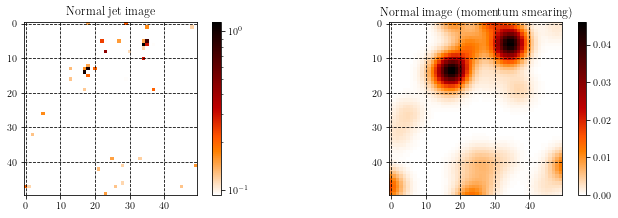

In [169]:
singlet.plot_normal(1,50,50)

Runing Riemann analysis: 100%|██████████████| 467/467 [00:00<00:00, 6214.75it/s]


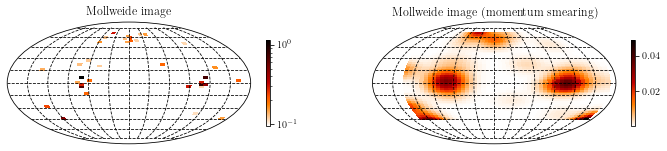

In [170]:
singlet.plot_mollweide(1,50,50,3)